In [1]:
"""
Distributed HMC
Author: Peter July 2023

Originally inspired by this example:
https://colab.research.google.com/github/tensorflow/probability/blob/master/spinoffs/oryx/examples/notebooks/probabilistic_programming.ipynb#scrollTo=nmjmxzGhN855

# New Requirements:
# conda install python=3.9 numpy scipy pandas matplotlib
# conda install -c anaconda cudatoolkit
# pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# pip install jax pip tensorflow-probability 
# pip install matplotlib

"""
import os
os.environ["KERAS_BACKEND"] = "jax"  # Must be specified before loading keras_core
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # CPU is faster for batchsize=1 inference.

import keras_core as keras
import jax
import jax.numpy as jnp
from jax import random, vmap, jit, grad
#assert jax.default_backend() == 'gpu'
import utils
import numpy as np
import pandas as pd
import time
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
#import elegy # pip install elegy. # Trying to do this with keras core instead.
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
# %load_ext autoreload
# %autoreload 2

# Run in DEBUG mode if there is no slurm task id.
try:
    SLURM_ARRAY_TASK_ID = int(os.environ['SLURM_ARRAY_TASK_ID'])
    SLURM_ARRAY_JOB_ID = int(os.environ['SLURM_ARRAY_JOB_ID'])
    DEBUG = False
except:
    print(f'DEBUG MODE: Could not load SLURM_ARRAY_TASK_ID. Assuming we are debugging.')
    SLURM_ARRAY_TASK_ID = 0
    SLURM_ARRAY_JOB_ID = 0
    DEBUG = True
    

def index_mcmc_runs():
    """Make a list of combinations for which we want to run MCMC."""
    experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
    dfs = []
    for experiment_name in experiments:
        filename = f'../data/2023/{experiment_name}_heliosphere.dat'
        df = utils.index_experiment_files(filename) 
        df['experiment_name'] = experiment_name
        df['filename_heliosphere'] = filename
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=0)
    return df

# Select experiment parameters
df = index_mcmc_runs()  # List of all ~200 experiments.
print(f'Found {df.shape[0]} combinations to run MCMC on. Performing MCMC on index {SLURM_ARRAY_TASK_ID}.')
df = df.iloc[SLURM_ARRAY_TASK_ID]

# Model specification
version = 'v1.0'

# Setup  output directory.
results_dir = f'../../results/{version}/'
Path(results_dir).mkdir(parents=True, exist_ok=True)

# Load observation data and define logprob. 
specified_parameters = utils.get_parameters(df.filename_heliosphere, df.interval)
data_path = f'../data/oct2022/{df.experiment_name}/{df.experiment_name}_{df.interval}.dat'  # This data is the same.
model_path = f'../models/model_{version}_{df.polarity}.keras'
seed = SLURM_ARRAY_TASK_ID + SLURM_ARRAY_JOB_ID
penalty = 1e6
target_log_prob = utils.define_log_prob(model_path, data_path, specified_parameters, penalty=penalty)

# Hyperparameters for MCMC
if DEBUG:
    # For running interactive tests.
    num_results = 500 #150000 #500000 # 10k takes 11min. About 1/5 of these accepted? now .97
    num_burnin_steps = 100 #500
    num_adaptation_steps = np.floor(.8*num_burnin_steps) #Somewhat smaller than number of burnin
    target_accept_prob = 0.3
    step_size = 1e-3 # 1e-3 (experiment?) # 1e-5 has 0.95 acc rate and moves. 1e-4 0.0 acc.
    num_leapfrog_steps = 100
    max_tree_depth = 10 # Default=10. Smaller results in shorter steps. Larger takes memory.
else:
    num_results = 110000 #150000 #500000 # 10k takes 11min. About 1/5 of these accepted? now .97
    num_burnin_steps = 1000 #500
    num_adaptation_steps = np.floor(.8*num_burnin_steps) #Somewhat smaller than number of burnin
    target_accept_prob = 0.3
    step_size = 1e-3 # 1e-3 (experiment?) # 1e-5 has 0.95 acc rate and moves. 1e-4 0.0 acc.
    num_leapfrog_steps = 100
    max_tree_depth = 10 # Default=10. Smaller results in shorter steps. Larger takes memory.

@jit
def run_chain(key, state):
    #kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps)
    max_energy_diff = 1000 #1e32 #1e21 # Default 1000.0. Divergent samples are those that exceed this.
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, step_size=step_size, max_tree_depth=max_tree_depth, 
                                     max_energy_diff=max_energy_diff, unrolled_leapfrog_steps=1,)
    def trace_fn(_, pkr):
        return [pkr.log_accept_ratio,
                pkr.target_log_prob,
                pkr.step_size]
    
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        kernel,
        num_adaptation_steps=int(num_burnin_steps * 0.8),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(step_size=new_step_size),
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,
    )
    def trace_fn(_, pkr):
        return [pkr.inner_results.log_accept_ratio,
                pkr.inner_results.target_log_prob,
                pkr.inner_results.step_size]
    
    samples, pkr = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        kernel=kernel,
        trace_fn=trace_fn,
        current_state=state,
        seed=key)
    
    return samples, pkr


start_time = time.time()
np.random.seed(seed)
state = np.random.random((5,)) #jnp.random.random((5,), dtype='float32') # used for 29091984
#state = jnp.array(utils.minmax_scale_input(np.array([90, .5, 1.7, 1.4, 1.1 ]))) # This is ~MLE
#state = 0.5 * jnp.ones((5,), dtype='float32')
key = random.PRNGKey(seed)
samples_transformed_all, pkr_all = run_chain(key, state)
# Remove duplicates.
samples_transformed, pkr = utils.remove_consecutive_duplicates(samples_transformed_all, pkr_all, atol=0.0)
log_accept_ratio, log_probs, step_sizes  = pkr
#all_log_accept_ratio, all_log_probs, all_step_sizes = pkr_all
print('Finished in %d minutes.' % int((time.time() - start_time)//60))
print(f'Acceptance rate: {len(samples_transformed)/len(samples_transformed_all)}. Decrease step_size to increase rate.')

# Inverse transform samples.
samples = utils.untransform_input(samples_transformed)

# Save results: samples and plots
np.savetxt(fname=f'{results_dir}/samples_{SLURM_ARRAY_TASK_ID}_{df.experiment_name}_{df.interval}_{df.polarity}.csv', X=samples, delimiter=',')
np.savetxt(fname=f'{results_dir}/logprobs_{SLURM_ARRAY_TASK_ID}_{df.experiment_name}_{df.interval}_{df.polarity}.csv', X=log_probs, delimiter=',')
#np.savetxt(fname=f'{results_dir}/logacceptratio_{SLURM_ARRAY_TASK_ID}.csv', X=log_accept_ratio, delimiter=',')
#np.savetxt(fname=f'{results_dir}/stepsizes_{SLURM_ARRAY_TASK_ID}.csv', X=step_sizes, delimiter=',')

# Get NN predictions on these samples.
from preprocess import transform_input, untransform_input
specified_parameters_transformed = transform_input(jnp.array(specified_parameters).reshape((1,-1)))
xs = utils._form_batch(samples_transformed, specified_parameters_transformed)
model = keras.models.load_model(model_path)
predictions_transformed = model.predict(xs, verbose=2)
predictions = utils.untransform_output(predictions_transformed)
np.savetxt(fname=f'{results_dir}/predictions_{SLURM_ARRAY_TASK_ID}_{df.experiment_name}_{df.interval}_{df.polarity}.csv', X=predictions, delimiter=',')




2023-07-24 12:34:09.079568: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 12:34:09.157288: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 12:34:09.158334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 12:34:10.315692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using JAX backend.
DEBUG MODE: Could not load SLURM_ARRAY_TASK_ID. Assuming we are debugging.
Found 210 combinations to run MCMC on. Performing MCMC on index 0.
Finished in 0 minutes.
Acceptance rate: 0.998. Decrease step_size to increase rate.
16/16 - 0s - 13ms/step


In [21]:
print(samples.shape, log_probs.shape, predictions.shape)

(500, 5) (500,) (500, 32)


In [24]:
samples = np.random.rand(10,5)
consecutive_repeat_rows = np.all(np.isclose(samples[1:,:], samples[:-1,:], rtol=0.0), axis=1)
consecutive_repeat_rows = np.concatenate([np.array([False]), consecutive_repeat_rows])
consecutive_repeat_rows.shape

(10,)

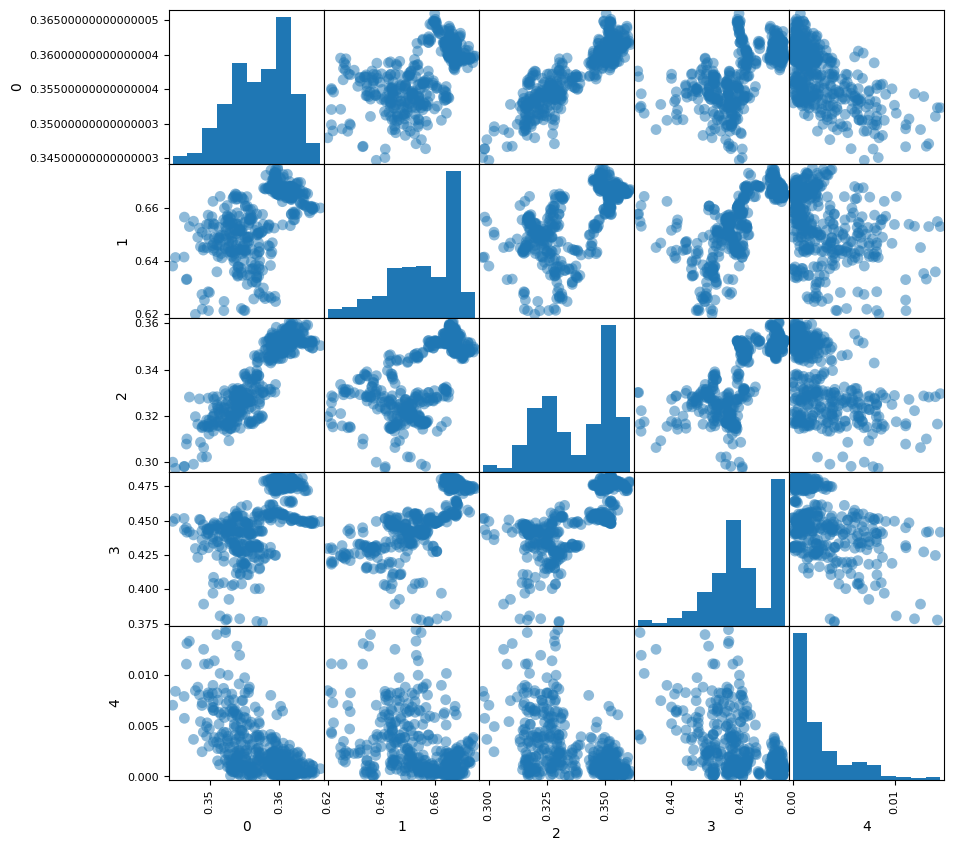

In [27]:
# N, D = samples_transformed.shape
# for d in range(D):
#     plt.h
import pandas as pd
df = pd.DataFrame(samples_transformed)
g = pd.plotting.scatter_matrix(df, figsize=(10,10), marker = 'o', hist_kwds = {'bins': 10}, s = 60, alpha = 0.5)



In [8]:
df.describe()

,0,1,2,3,4
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.355870,0.374028,0.389785,-0.307607,0.133359
std,0.018796,3.354820,0.485152,0.468173,0.102762
min,0.303441,-6.452361,-0.717931,-1.659340,-0.221764
25%,0.342548,-2.066169,0.131558,-0.603123,0.076222
50%,0.354106,0.505905,0.378919,-0.380523,0.146872
75%,0.366033,1.991727,0.770982,-0.033435,0.198948
max,0.426237,8.313313,1.342219,1.308743,0.434920


In [19]:
# Inspect training data normalization.
import h5py
path = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/2023_07_01/'
file = f'{path}/pos/model_collection_1AU_90deg_0deg_fixed_training.h5'

with h5py.File(file, 'r') as h5:
    X = h5['X_minmax'][-10000:,...]
    Y = h5['Y_log_scaled'][-10000:,...]

df = pd.DataFrame(X)
df.describe()



,0,1,2,3,4,5,6,7
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.407471,0.527300,0.557704,0.477038,0.473938,0.424095,0.503011,0.511733
std,0.304562,0.303760,0.322496,0.349875,0.345727,0.329322,0.326842,0.373614
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235294,0.285714,0.220779,0.230769,0.230769,0.157895,0.315789,0.333333
50%,0.352941,0.500000,0.532468,0.461538,0.461538,0.315789,0.473684,0.666667
75%,0.647059,0.714286,0.844156,0.692308,0.692308,0.684211,0.684211,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
